In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package
sys.path.append("../..")

# Third party imports
import numpy as np
import matplotlib.pyplot as plt


# Librep imports
# from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
# from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

In [3]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.metrics.report import ClassificationReport
from librep.estimators import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport

from librep.transforms.topo_ae import TopologicalDimensionalityReduction
# from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
from librep.transforms import UMAP
from tabulate import tabulate

2022-10-20 20:30:48.782168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 20:30:48.782187: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from Experiments_topoae_KuHar20Hz_helper import *
kuhar_data = obtainKuHar20Hz()
train_HD = kuhar_data['train_HD']
train_LD = kuhar_data['train_LD']
train_Y = kuhar_data['train_Y']
test_HD = kuhar_data['test_HD']
test_LD = kuhar_data['test_LD']
test_Y = kuhar_data['test_Y']

# Preparing Table

Columns:
* RF (Accuracy, F1)
* SVC (Accuracy, F1)
* KNN (Accuracy, F1)
* Trustworthiness
* Continuity
* Co-k-nearest-neighbor-size

Rows:
* UMAP (2 dim)
* Generic Autoencoders
* Topological autoencoders (L=1)
* Topological autoencoders (L=100)

In [5]:
def print_table(table_info):
    tabulated = tabulate(
        table_info,
        headers='keys',
        tablefmt='fancy_grid',
        missingval='-'
    )
    print(tabulated)


table_info = {
    'Metrics': ['RF-ACC', 'RF-F1',
                'SVC-ACC', 'SVC-F1',
                'KNN-ACC', 'KNN-F1',
                'Trustworthiness',
                'Continuity',
                'Co-k-NNs'],
    'UMAP': ['-']*9,
    'Generic-AE': ['-']*9,
    'Topo-AEv2 (L=1)': ['-']*9,
    'Topo-AEv2 (L=100)': ['-']*9
}
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │ Generic-AE   │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │ -            │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │ -            │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │ -            │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │ -            │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │ -            │ -         

# Visualization helper

In [6]:
def visualize(X, Y, filtered=None, xlim=None, ylim=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()

# Applying Scaler

MinMaxScaler, MaxAbsScaler and StandardScaler apply the scaling PER FEATURE, which means the distance between points would actually be modified, and so, the ranking as well.
Because of this, a new Scaler is used

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = 2*(np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x))
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [9]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()

In [10]:
# train_HD = scaler.fit_transform(train_dataset_fft.X)
# train_LD = None
# # train_Y = train_dataset_fft.y
# test_HD = scaler.fit_transform(test_dataset_fft.X)
# test_LD = None
# # test_Y = test_dataset_fft.y

## Set Reporter

In [11]:
reporter = ClassificationReport(
    use_accuracy=True, 
    use_f1_score=True,
    use_classification_report=False,
    use_confusion_matrix=False,
    plot_confusion_matrix=False
)

# **SECTION:** Reducing with Generic AE

The topological autoencoder can be used as a generic one by applying a lambda value of 0.

In [12]:
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 0
topo_reducer = TopologicalDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam = topoae_lambda,
    ae_kwargs = kwargs,
    input_shape = input_shape,
    patience=10
)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:301.2609, Loss-ae:301.2609, Loss-topo:117.4399
Epoch:2, P:10, Loss:316.4390, Loss-ae:316.4390, Loss-topo:158.3181
Epoch:3, P:9, Loss:267.8239, Loss-ae:267.8239, Loss-topo:99.3675
Epoch:4, P:10, Loss:236.9390, Loss-ae:236.9390, Loss-topo:186.6704
Epoch:5, P:10, Loss:222.3443, Loss-ae:222.3443, Loss-topo:859.0575
Epoch:6, P:10, Loss:200.1884, Loss-ae:200.1884, Loss-topo:1772.1042
Epoch:7, P:10, Loss:172.2327, Loss-ae:172.2327, Loss-topo:638.3725
Epoch:8, P:10, Loss:157.3069, Loss-ae:157.3069, Loss-topo:1220.4742
Epoch:9, P:10, Loss:147.7892, Loss-ae:147.7892, Loss-topo:1080.2198
Epoch:10, P:10, Loss:164.4362, Loss-ae:164.4362, Loss-topo:1781.4811
Epoch:11, P:9, Loss:158.8981, Loss-ae:158.8981, Loss-topo:2318.6553
Epoch:12, P:8, Loss:150.5031, Loss-ae:150.5031, Loss-topo:2043.8304
Epoch:13, P:7, Loss:160.3388, Loss-ae:160.3388, Loss-topo:3236.9208
Epoch:14, P:6, Loss:155.9067, Loss-ae:155.9067, Loss-topo:1743.1869
Epoch:15, P:5, Loss:165.6604, Loss-ae:165.6604, Loss-to

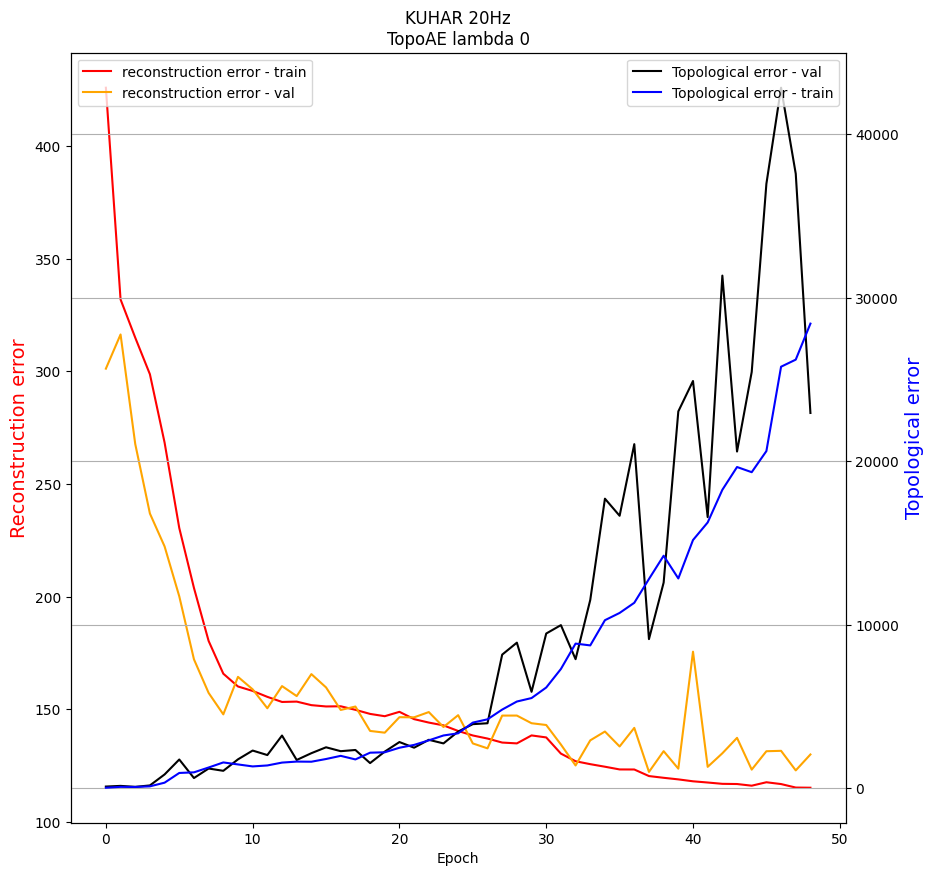

In [13]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [14]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [15]:
train_pmd = create_PandasMultiModalDataset(train_LD, train_Y)
test_pmd = create_PandasMultiModalDataset(test_LD, test_Y)

## Experiment for Random Forest

In [16]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [17]:
result = multi_run_experiment(train_pmd, test_pmd)

In [18]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.469047619047619
F1 0.4858671024294313


In [19]:
table_info['Generic-AE'][0] = accuracy
table_info['Generic-AE'][1] = f1
print_table(table_info)

╒═════════════════╤════════╤════════════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │ Generic-AE         │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪════════════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │ 0.469047619047619  │ -                 │ -                   │
├─────────────────┼────────┼────────────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │ 0.4858671024294313 │ -                 │ -                   │
├─────────────────┼────────┼────────────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │ -                  │ -                 │ -                   │
├─────────────────┼────────┼────────────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │ -                  │ -                 │ -                   │
├─────────────────┼────────┼────────────────────┼───────────────────┼───────────

## Experiment for SVC

In [20]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [21]:
result = multi_run_experiment(train_pmd, test_pmd)

In [22]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.3306878306878307
F1 0.38376664854705833


In [23]:
table_info['Generic-AE'][2] = accuracy
table_info['Generic-AE'][3] = f1
print_table(table_info)

╒═════════════════╤════════╤═════════════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │ Generic-AE          │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪═════════════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │ 0.469047619047619   │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │ 0.4858671024294313  │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │ 0.3306878306878307  │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │ 0.38376664854705833 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼

## Experiment for KNN

In [24]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [25]:
result = multi_run_experiment(train_pmd, test_pmd)

In [26]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.42592592592592593
F1 0.44178338776725007


In [27]:
table_info['Generic-AE'][4] = accuracy
table_info['Generic-AE'][5] = f1
print_table(table_info)

╒═════════════════╤════════╤═════════════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │ Generic-AE          │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪═════════════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │ 0.469047619047619   │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │ 0.4858671024294313  │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │ 0.3306878306878307  │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │ 0.38376664854705833 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼

## Obtain quality metrics

In [28]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [29]:
metrics_report

{'residual variance (pearson)': 0.12996463541605052,
 'residual variance (spearman)': 0.15157602117129687,
 'trustworthiness': 0.8764401493052749,
 'continuity': 0.947644419054057,
 'co k nearest neighbor size': 0.40384615384615385,
 'local continuity meta criterion': 0.36129296235679215,
 'local property': 0.5180264577510715,
 'global property': 0.8924065616015839}

In [30]:
table_info['Generic-AE'][6] = metrics_report['trustworthiness']
table_info['Generic-AE'][7] = metrics_report['continuity']
table_info['Generic-AE'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.469048 │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.485867 │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.330688 │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.383767 │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.425926 │ -         

## Visualization

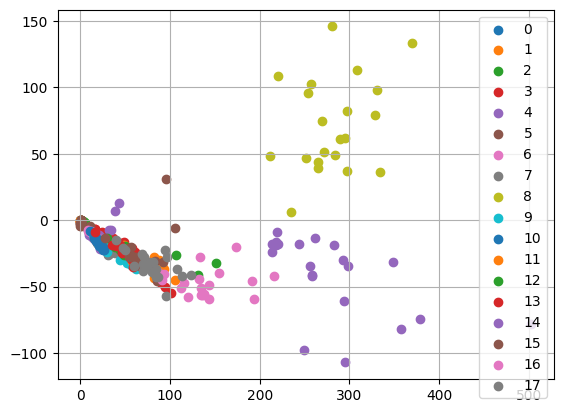

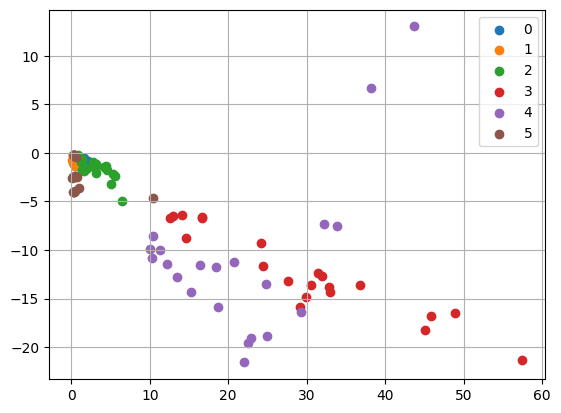

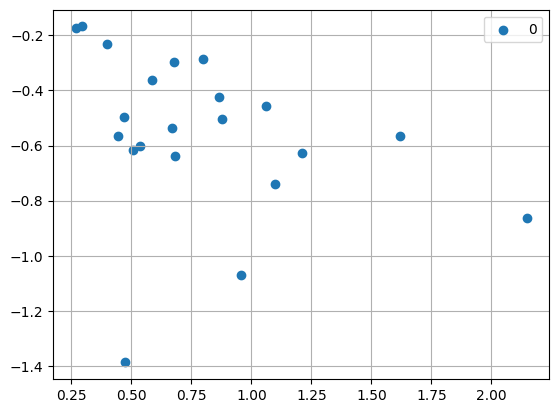

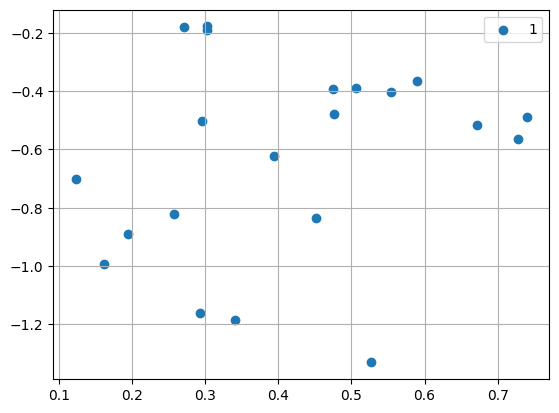

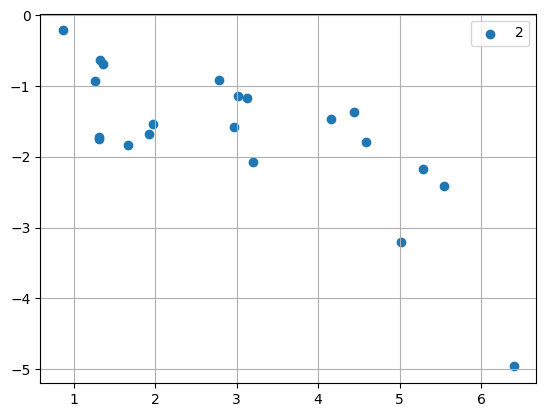

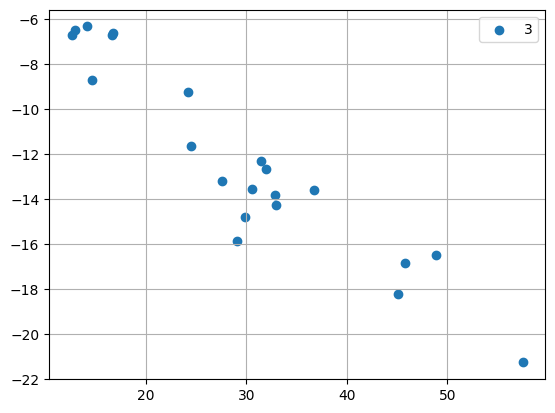

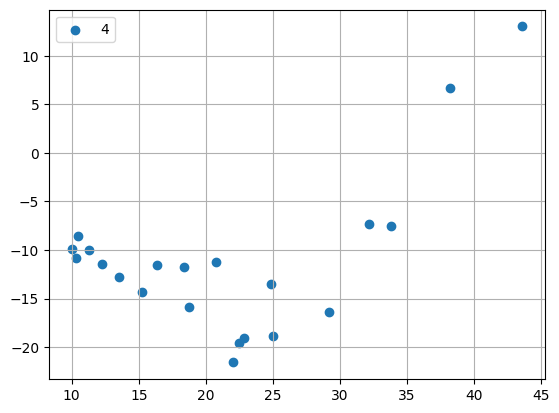

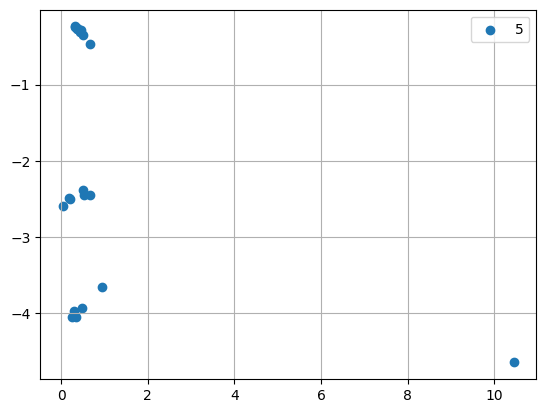

In [31]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Topological AE (lambda=1)

In [32]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 1
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:309.7807, Loss-ae:282.2831, Loss-topo:27.4976
Epoch:2, P:10, Loss:279.0118, Loss-ae:270.8872, Loss-topo:8.1246
Epoch:3, P:10, Loss:289.1170, Loss-ae:281.1131, Loss-topo:8.0039
Epoch:4, P:9, Loss:282.2359, Loss-ae:272.7269, Loss-topo:9.5090
Epoch:5, P:8, Loss:228.8951, Loss-ae:225.7544, Loss-topo:3.1407
Epoch:6, P:10, Loss:216.5721, Loss-ae:214.8924, Loss-topo:1.6797
Epoch:7, P:10, Loss:243.2139, Loss-ae:241.2025, Loss-topo:2.0114
Epoch:8, P:9, Loss:211.4047, Loss-ae:206.0944, Loss-topo:5.3103
Epoch:9, P:10, Loss:209.1534, Loss-ae:201.6206, Loss-topo:7.5328
Epoch:10, P:10, Loss:240.8006, Loss-ae:234.1526, Loss-topo:6.6480
Epoch:11, P:9, Loss:182.8992, Loss-ae:178.2218, Loss-topo:4.6774
Epoch:12, P:10, Loss:175.9531, Loss-ae:171.7014, Loss-topo:4.2518
Epoch:13, P:10, Loss:191.9764, Loss-ae:186.6037, Loss-topo:5.3728
Epoch:14, P:9, Loss:156.1552, Loss-ae:152.7755, Loss-topo:3.3797
Epoch:15, P:10, Loss:155.8685, Loss-ae:151.7702, Loss-topo:4.0983
Epoch:16, P:10, Loss:16

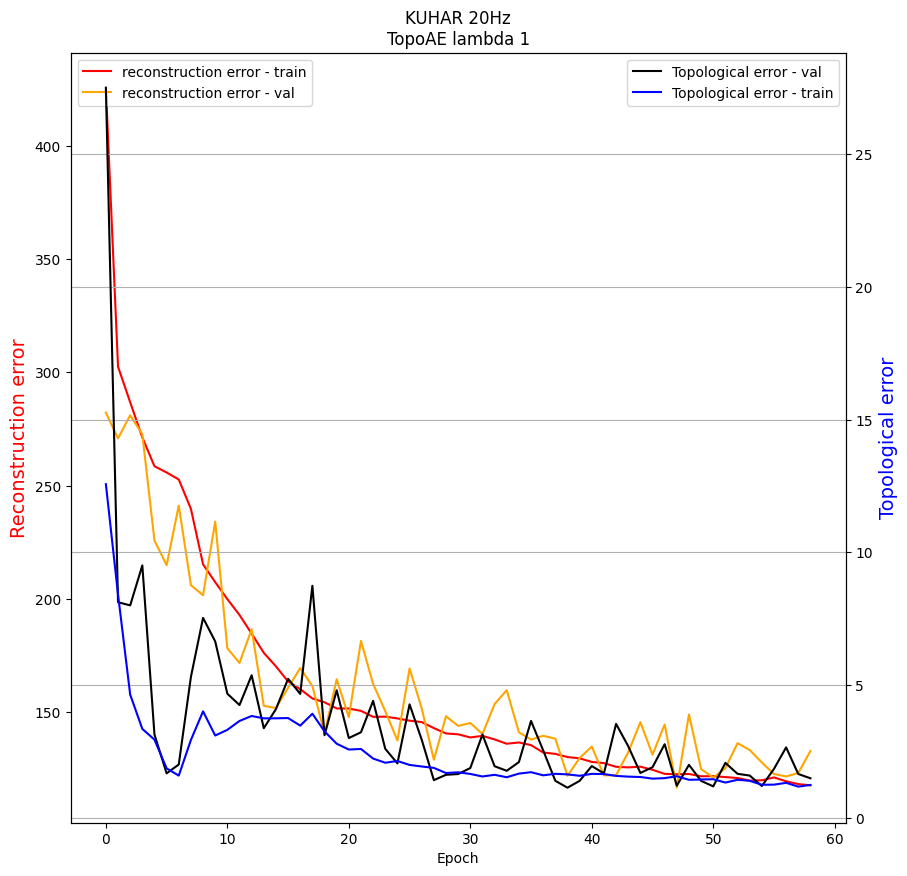

In [33]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [34]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [35]:
train_pmd = create_PandasMultiModalDataset(train_LD, train_Y)
test_pmd = create_PandasMultiModalDataset(test_LD, test_Y)

## Experiment for Random Forest

In [36]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [37]:
result = multi_run_experiment(train_pmd, test_pmd)

In [38]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.4714285714285714
F1 0.48699165381373966


In [39]:
table_info['Topo-AEv2 (L=1)'][0] = accuracy
table_info['Topo-AEv2 (L=1)'][1] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═════════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)     │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═════════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.469048 │ 0.4714285714285714  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.485867 │ 0.48699165381373966 │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.330688 │ -                   │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.383767 │ -                   │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │    

## Experiment for SVC

In [40]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [41]:
result = multi_run_experiment(train_pmd, test_pmd)

In [42]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.42592592592592593
F1 0.46962027091657055


In [43]:
table_info['Topo-AEv2 (L=1)'][2] = accuracy
table_info['Topo-AEv2 (L=1)'][3] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═════════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)     │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═════════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.469048 │ 0.4714285714285714  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.485867 │ 0.48699165381373966 │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.330688 │ 0.42592592592592593 │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.383767 │ 0.46962027091657055 │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │    

## Experiment for KNN

In [44]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [45]:
result = multi_run_experiment(train_pmd, test_pmd)

In [46]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.4576719576719577
F1 0.4705089866518147


In [47]:
table_info['Topo-AEv2 (L=1)'][4] = accuracy
table_info['Topo-AEv2 (L=1)'][5] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═════════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)     │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═════════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.469048 │ 0.4714285714285714  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.485867 │ 0.48699165381373966 │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.330688 │ 0.42592592592592593 │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.383767 │ 0.46962027091657055 │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │    

## Obtain quality metrics

In [48]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [49]:
metrics_report

{'residual variance (pearson)': 0.1362817666080166,
 'residual variance (spearman)': 0.20996846763549937,
 'trustworthiness': 0.8909509394035137,
 'continuity': 0.957242352880666,
 'co k nearest neighbor size': 0.4020225464190981,
 'local continuity meta criterion': 0.3594693549297364,
 'local property': 0.5110422131769377,
 'global property': 0.8779189313690987}

In [50]:
table_info['Topo-AEv2 (L=1)'][6] = metrics_report['trustworthiness']
table_info['Topo-AEv2 (L=1)'][7] = metrics_report['continuity']
table_info['Topo-AEv2 (L=1)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.469048 │          0.471429 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.485867 │          0.486992 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.330688 │          0.425926 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.383767 │          0.46962  │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.425926 │          0

## Visualization

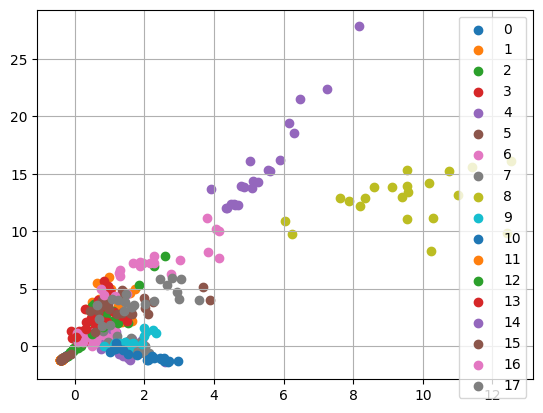

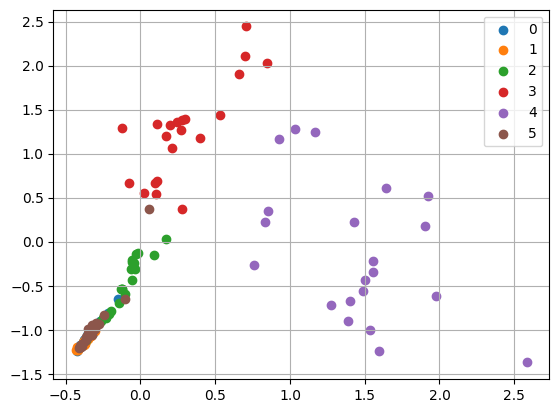

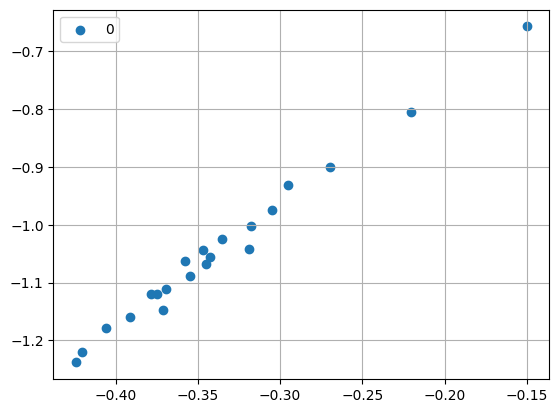

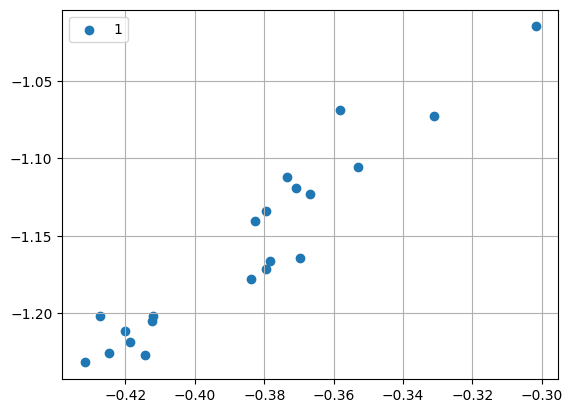

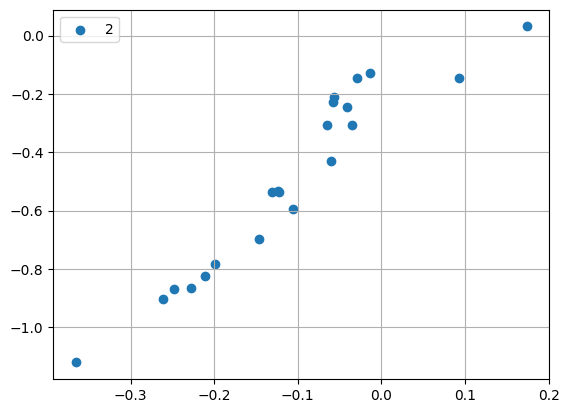

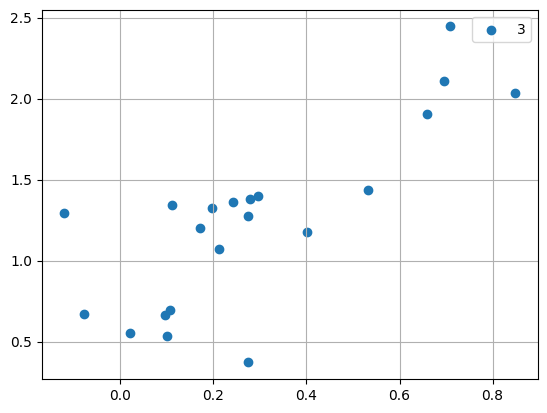

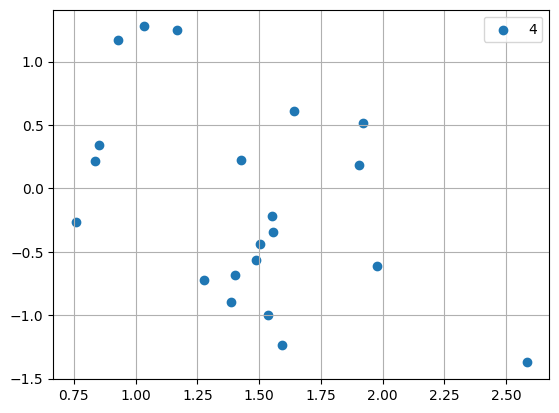

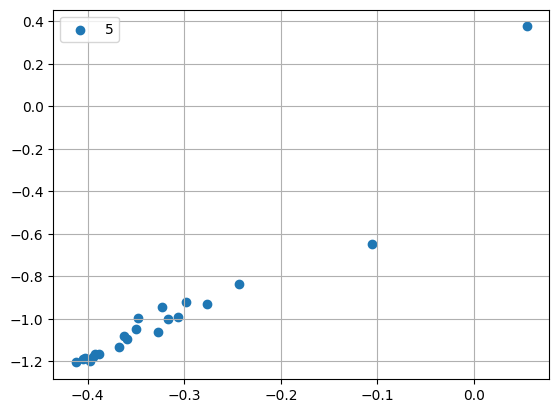

In [51]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Topological AE (lambda=100)

In [52]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 100
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:424.1672, Loss-ae:389.2135, Loss-topo:0.3495
Epoch:2, P:10, Loss:381.0618, Loss-ae:294.6217, Loss-topo:0.8644
Epoch:3, P:10, Loss:311.8373, Loss-ae:263.2399, Loss-topo:0.4860
Epoch:4, P:10, Loss:236.0595, Loss-ae:233.3525, Loss-topo:0.0271
Epoch:5, P:10, Loss:366.1098, Loss-ae:359.4418, Loss-topo:0.0667
Epoch:6, P:9, Loss:245.5729, Loss-ae:242.4730, Loss-topo:0.0310
Epoch:7, P:8, Loss:228.1080, Loss-ae:226.2927, Loss-topo:0.0182
Epoch:8, P:10, Loss:225.6213, Loss-ae:224.6931, Loss-topo:0.0093
Epoch:9, P:10, Loss:211.6023, Loss-ae:210.5312, Loss-topo:0.0107
Epoch:10, P:10, Loss:207.8911, Loss-ae:207.0147, Loss-topo:0.0088
Epoch:11, P:10, Loss:212.3727, Loss-ae:209.5386, Loss-topo:0.0283
Epoch:12, P:9, Loss:209.4995, Loss-ae:207.1717, Loss-topo:0.0233
Epoch:13, P:8, Loss:221.3596, Loss-ae:213.8560, Loss-topo:0.0750
Epoch:14, P:7, Loss:224.3098, Loss-ae:217.7806, Loss-topo:0.0653
Epoch:15, P:6, Loss:182.8520, Loss-ae:176.9268, Loss-topo:0.0593
Epoch:16, P:10, Loss:190.

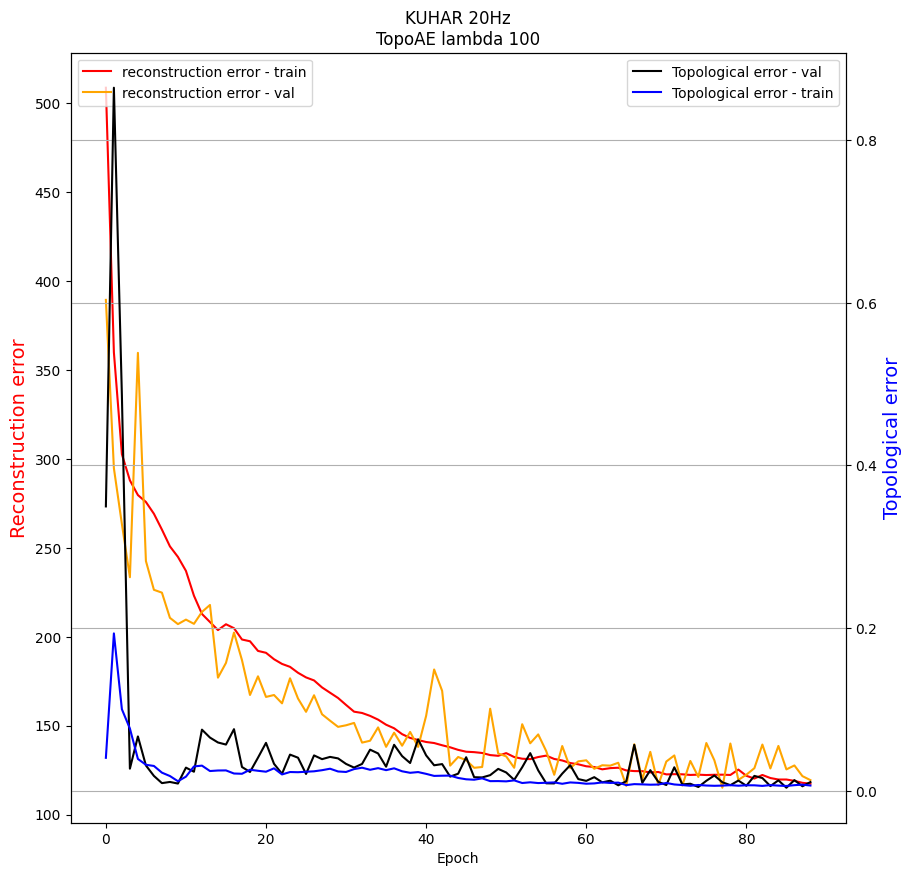

In [53]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [54]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [55]:
train_pmd = create_PandasMultiModalDataset(train_LD, train_Y)
test_pmd = create_PandasMultiModalDataset(test_LD, test_Y)

## Experiment for Random Forest

In [56]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [57]:
result = multi_run_experiment(train_pmd, test_pmd)

In [58]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.501058201058201
F1 0.5042108762236855


In [59]:
table_info['Topo-AEv2 (L=100)'][0] = accuracy
table_info['Topo-AEv2 (L=100)'][1] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.469048 │          0.471429 │ 0.501058201058201   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.485867 │          0.486992 │ 0.5042108762236855  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.330688 │          0.425926 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.383767 │          0.46962  │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.425926 │          0

## Experiment for SVC

In [60]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [61]:
result = multi_run_experiment(train_pmd, test_pmd)

In [62]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.48148148148148145
F1 0.5107613083983553


In [63]:
table_info['Topo-AEv2 (L=100)'][2] = accuracy
table_info['Topo-AEv2 (L=100)'][3] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.469048 │          0.471429 │ 0.501058201058201   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.485867 │          0.486992 │ 0.5042108762236855  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.330688 │          0.425926 │ 0.48148148148148145 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.383767 │          0.46962  │ 0.5107613083983553  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.425926 │          0

## Experiment for KNN

In [64]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [65]:
result = multi_run_experiment(train_pmd, test_pmd)

In [66]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.4894179894179894
F1 0.490015160869794


In [67]:
table_info['Topo-AEv2 (L=100)'][4] = accuracy
table_info['Topo-AEv2 (L=100)'][5] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.469048 │          0.471429 │ 0.501058201058201   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.485867 │          0.486992 │ 0.5042108762236855  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.330688 │          0.425926 │ 0.48148148148148145 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.383767 │          0.46962  │ 0.5107613083983553  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.425926 │          0

## Obtain quality metrics

In [68]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [69]:
metrics_report

{'residual variance (pearson)': 0.34470202113449266,
 'residual variance (spearman)': 0.4869155369872554,
 'trustworthiness': 0.8707342006069201,
 'continuity': 0.9416629315855602,
 'co k nearest neighbor size': 0.3789787798408488,
 'local continuity meta criterion': 0.3364255883514871,
 'local property': 0.48069371409046635,
 'global property': 0.8275684811771735}

In [70]:
table_info['Topo-AEv2 (L=100)'][6] = metrics_report['trustworthiness']
table_info['Topo-AEv2 (L=100)'][7] = metrics_report['continuity']
table_info['Topo-AEv2 (L=100)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.469048 │          0.471429 │            0.501058 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.485867 │          0.486992 │            0.504211 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.330688 │          0.425926 │            0.481481 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.383767 │          0.46962  │            0.510761 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.425926 │          0

## Visualization

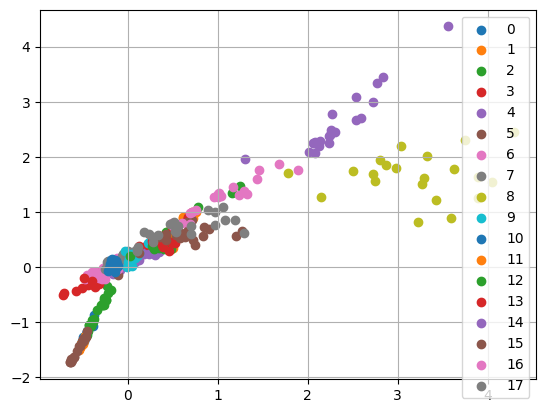

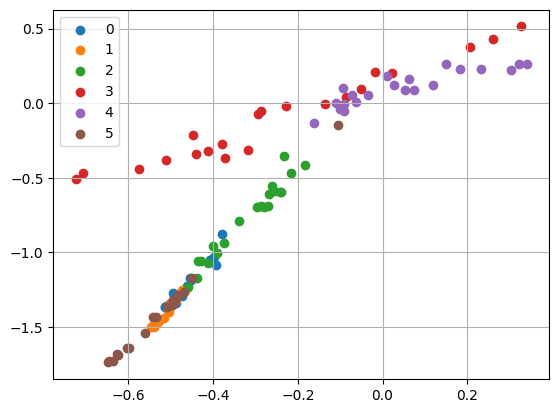

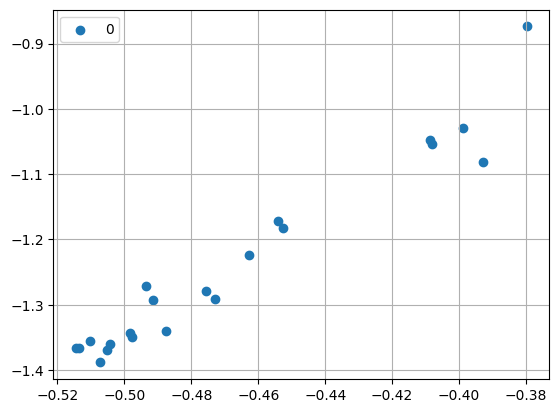

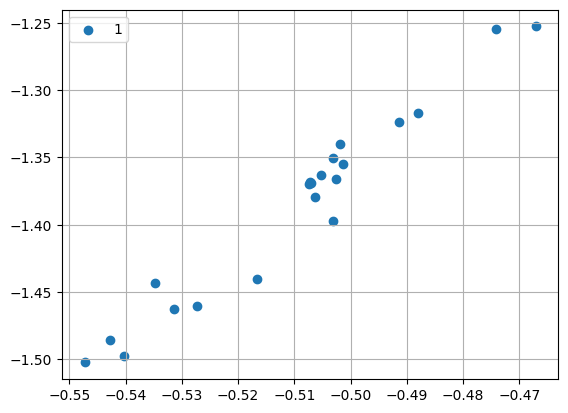

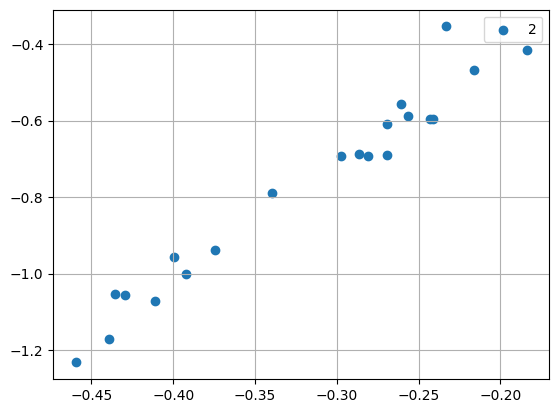

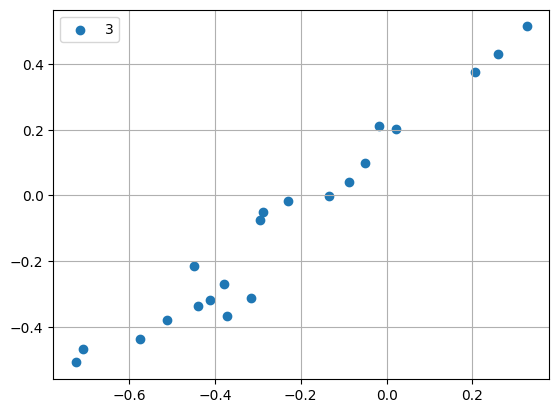

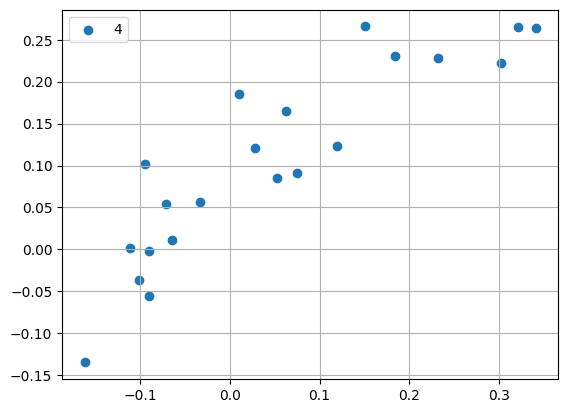

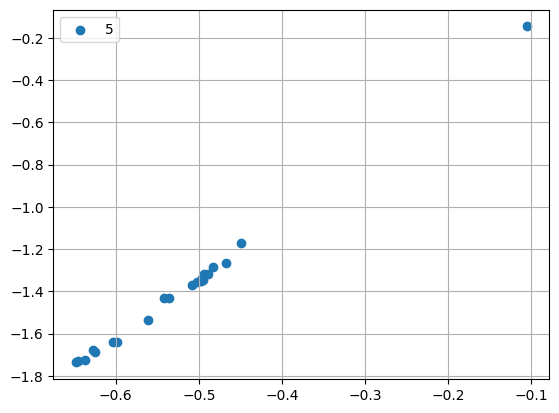

In [71]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** UMAP

In [72]:
umap_reducer = UMAP()
umap_reducer.fit(train_HD, train_Y)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [73]:
train_LD = np.reshape(umap_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(umap_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [74]:
train_pmd = create_PandasMultiModalDataset(train_LD, train_Y)
test_pmd = create_PandasMultiModalDataset(test_LD, test_Y)

## Experiment for Random Forest

In [75]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [76]:
result = multi_run_experiment(train_pmd, test_pmd)

In [77]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.8023809523809524
F1 0.8072154112441605


In [78]:
table_info['UMAP'][0] = accuracy
table_info['UMAP'][1] = f1
print_table(table_info)

╒═════════════════╤════════════════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP               │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪════════════════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ 0.8023809523809524 │     0.469048 │          0.471429 │            0.501058 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ 0.8072154112441605 │     0.485867 │          0.486992 │            0.504211 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -                  │     0.330688 │          0.425926 │            0.481481 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -                  │     0.383767 │          0.46962  │            0.510761 │
├─────────────────┼─

## Experiment for SVC

In [94]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [96]:
result = multi_run_experiment(train_pmd, test_pmd)

In [81]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.8095238095238095
F1 0.8133463884462848


In [82]:
table_info['UMAP'][2] = accuracy
table_info['UMAP'][3] = f1
print_table(table_info)

╒═════════════════╤════════════════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP               │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪════════════════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ 0.8023809523809524 │     0.469048 │          0.471429 │            0.501058 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ 0.8072154112441605 │     0.485867 │          0.486992 │            0.504211 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ 0.8095238095238095 │     0.330688 │          0.425926 │            0.481481 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ 0.8133463884462848 │     0.383767 │          0.46962  │            0.510761 │
├─────────────────┼─

## Experiment for KNN

In [91]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [97]:
result = multi_run_experiment(train_pmd, test_pmd)

In [85]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.7962962962962963
F1 0.8003604543412906


In [86]:
table_info['UMAP'][4] = accuracy
table_info['UMAP'][5] = f1
print_table(table_info)

╒═════════════════╤════════════════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP               │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪════════════════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ 0.8023809523809524 │     0.469048 │          0.471429 │            0.501058 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ 0.8072154112441605 │     0.485867 │          0.486992 │            0.504211 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ 0.8095238095238095 │     0.330688 │          0.425926 │            0.481481 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ 0.8133463884462848 │     0.383767 │          0.46962  │            0.510761 │
├─────────────────┼─

## Obtain quality metrics

In [87]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [88]:
metrics_report

{'residual variance (pearson)': 0.8464212792511916,
 'residual variance (spearman)': 0.8401534661931411,
 'trustworthiness': 0.8869032748701293,
 'continuity': 0.8766895118922533,
 'co k nearest neighbor size': 0.47015915119363394,
 'local continuity meta criterion': 0.42760595970427223,
 'local property': 0.3787411056376574,
 'global property': 0.6785989661230619}

In [89]:
table_info['UMAP'][6] = metrics_report['trustworthiness']
table_info['UMAP'][7] = metrics_report['continuity']
table_info['UMAP'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤══════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │     UMAP │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪══════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ 0.802381 │     0.469048 │          0.471429 │            0.501058 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ 0.807215 │     0.485867 │          0.486992 │            0.504211 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ 0.809524 │     0.330688 │          0.425926 │            0.481481 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ 0.813346 │     0.383767 │          0.46962  │            0.510761 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ 0.796296 │  

## Visualization

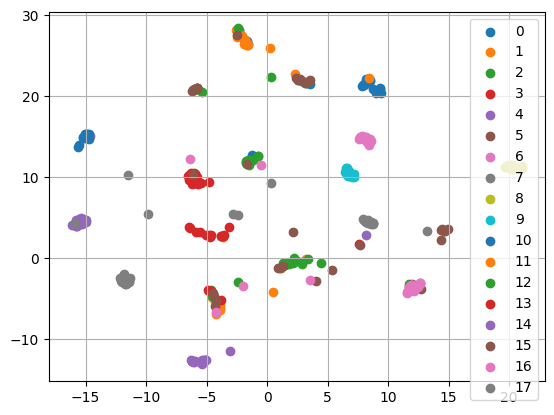

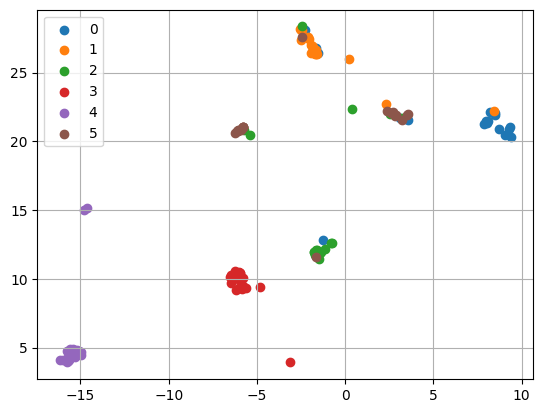

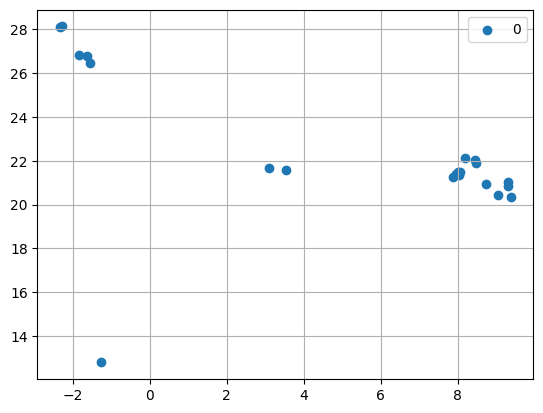

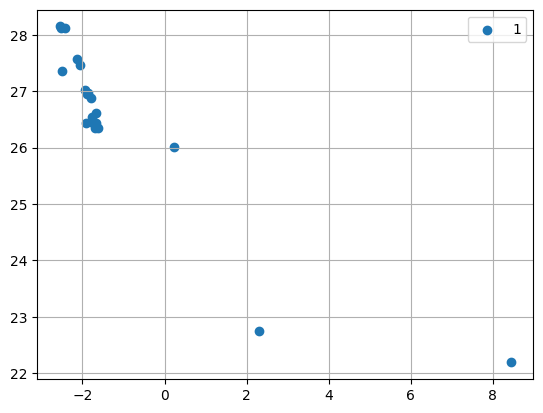

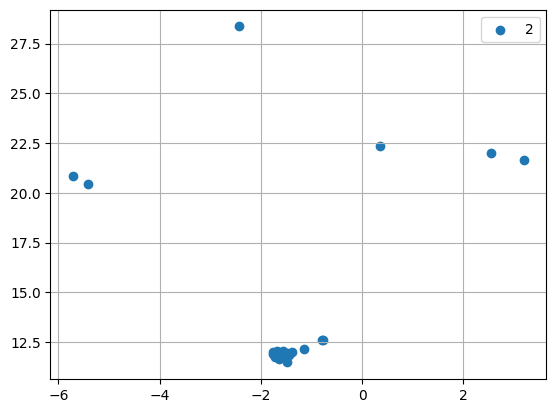

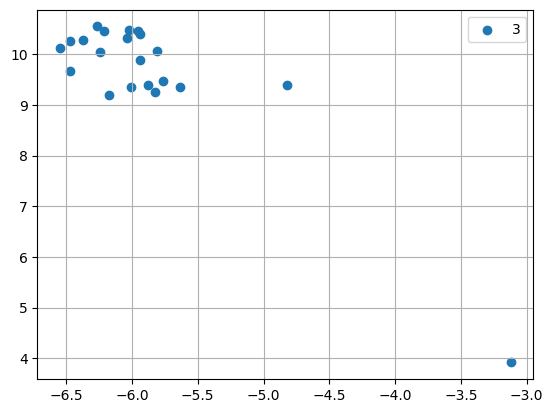

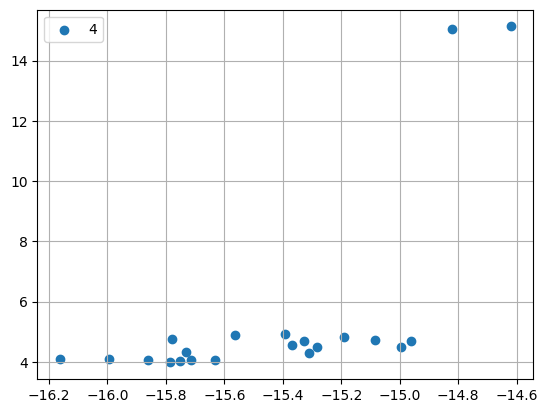

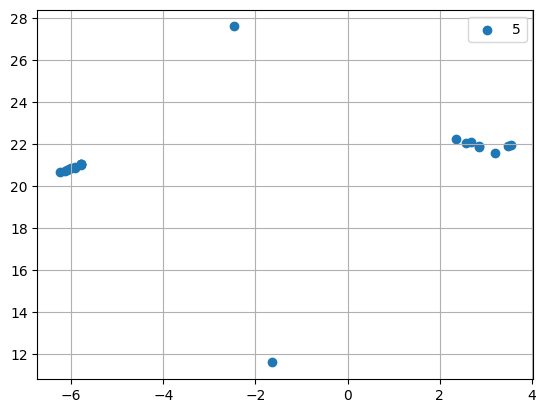

In [90]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run